In [ ]:
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
!echo "JAVA_HOME set to:" $JAVA_HOME

JAVA_HOME set to: /usr/lib/jvm/java-11-openjdk-amd64


In [ ]:
!pip install sklearn2pmml xgboost --upgrade
!pip install skl2onnx onnxruntime --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import skl2onnx
from skl2onnx.common.data_types import FloatTensorType, StringTensorType

# 1. LOAD DATA

In [ ]:
file_path = '/content/drive/MyDrive/MESTRADO/ELSAI/dataset_filtered.csv'
dataset = pd.read_csv(file_path)

In [ ]:
dataset = dataset.sample(frac=1)
dataset

,Strategy,Application,Module,Device,Instances,Delay,Network,EnergyConsumption,DeviceMaxCPU,DeviceCPUUsage,...,TupleCpuLength,SEED,UplinkBandwidth,DownlinkBandwidth,UplinkLatency,TupleNwLength,DeviceLevel,Simulation,Rate,ModuleCpuLoad
2608,CB-E,DCNS,object_tracker,d-0,3,123.48,9269.35,10128.84,4000.0,3743.43,...,1069.55,428956419,10000.0,10000.0,50.0,100.0,1,4,0.500,534.7750
2885,CB-E,DCNS,object_detector,d-1-0,1,511.80,10972.05,9966.94,2000.0,1841.55,...,1841.55,794161987,10000.0,10000.0,25.0,2000.0,1,6,0.500,920.7750
1066,ELSA,DCNS,object_detector,d-0,2,429.37,87636.90,10312.00,4000.0,3811.69,...,2178.11,633816299,10000.0,10000.0,50.0,2000.0,1,9,0.500,1089.0550
25,ELSA,DCNS,object_tracker,d-0,1,27.14,10848.70,3751.87,4000.0,1367.05,...,911.37,1835732737,10000.0,10000.0,50.0,100.0,1,1,0.500,455.6850
3139,CB-E,VRGame,connector,d-1-0,8,0.00,4471.50,8780.92,2000.0,1620.56,...,920.78,794161987,10000.0,10000.0,25.0,1000.0,1,8,0.010,9.2078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,Edgewards,DCNS,user_interface,cloud,9,0.00,492866.60,53643.06,44800.0,14010.64,...,514.62,1145661099,100.0,10000.0,0.0,2000.0,0,9,0.025,12.8655
2448,CB-E,DCNS,object_detector,d-1-0,1,3.64,5215.55,8369.32,2000.0,1543.87,...,2058.50,1145661099,10000.0,10000.0,25.0,2000.0,1,2,0.500,1029.2500
2183,CB-E,Translation_Service,processingModule,d-1-0,4,833.80,2727.00,10578.89,2000.0,1955.57,...,3602.37,1145661099,10000.0,10000.0,25.0,500.0,1,11,0.100,360.2370
206,ELSA,Translation_Service,processingModule,d-0,8,512.63,26821.00,10578.89,4000.0,3911.14,...,3602.37,1145661099,10000.0,10000.0,50.0,500.0,1,11,0.100,360.2370


In [ ]:
dataset.to_csv('/content/drive/MyDrive/MESTRADO/ELSAI/dataset.csv')

# 2. DEFINE FEATURES

In [ ]:
numeric_features = ['DeviceMaxCPU', 'ModuleMIPS', 'TupleCpuLength', 'Rate', 'Instances']
categorical_features = ['Application', 'Module', 'Device']
target = 'EnergyConsumption'

X = dataset[numeric_features + categorical_features]
y = np.log1p(dataset[target]) # Log transform for better training

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. DEFINE PREPROCESSOR & PIPELINE

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# 4. TRAIN

In [ ]:
print("Training Random Forest for EnergyConsumption...")
rf_pipeline.fit(X_train, y_train)

Training Random Forest for EnergyConsumption...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['DeviceMaxCPU', 'ModuleMIPS',
                                                   'TupleCpuLength', 'Rate',
                                                   'Instances']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Application', 'Module',
                                                   'Device'])])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

# 5. EVALUATION

In [ ]:
print("Model Evaluation (Original Scale)")
y_pred_log = rf_pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

print(f"R-squared: {r2_score(y_test_orig, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test_orig, y_pred):.4f}")

Model Evaluation (Original Scale)
R-squared: 0.9534
MAE: 1478.9216


# 6. TARGETED TESTING

In [ ]:
print("Scenario Testing: Energy Consumption by Device Capacity")

# Define our scenarios
test_devices = [2000.0, 2800.0, 4000.0, 44800.0]
test_devices_names = ["d-1-0", "d-1", "d-0", "cloud"]
test_modules = dataset['Module'].unique()[:5]

scenario_results = []

for i, dev_cpu in enumerate(test_devices):
    for mod in test_modules:
        sample = pd.DataFrame({
            'DeviceMaxCPU': [dev_cpu],
            'ModuleMIPS': [dataset['ModuleMIPS'].mean()],
            'TupleCpuLength': [dataset['TupleCpuLength'].mean()],
            'Rate': [dataset['Rate'].mean()],
            'Instances': [1],
            'Application': [dataset['Application'].iloc[0]],
            'Module': [mod],
            'Device': [test_devices_names[i]]
        })

        pred_log = rf_pipeline.predict(sample)
        pred_val = np.expm1(pred_log)[0]

        scenario_results.append({
            'DeviceName': test_devices_names[i],
            'DeviceMaxCPU': dev_cpu,
            'Module': mod,
            'Predicted_Energy': round(pred_val, 2)
        })

df_scenarios = pd.DataFrame(scenario_results)

pivot_table = df_scenarios.pivot(index='Module', columns='DeviceName', values='Predicted_Energy')
pivot_table

Scenario Testing: Energy Consumption by Device Capacity


DeviceName,cloud,d-0,d-1,d-1-0
Module,,,,
connector,2750.97,2602.65,4536.74,6291.18
object_detector,2750.97,2471.33,4443.91,6326.40
object_tracker,2774.17,2810.49,4642.74,6225.05
processingModule,2572.20,2578.05,4497.52,6212.98
user_interface,2231.92,2598.64,4529.20,6280.73


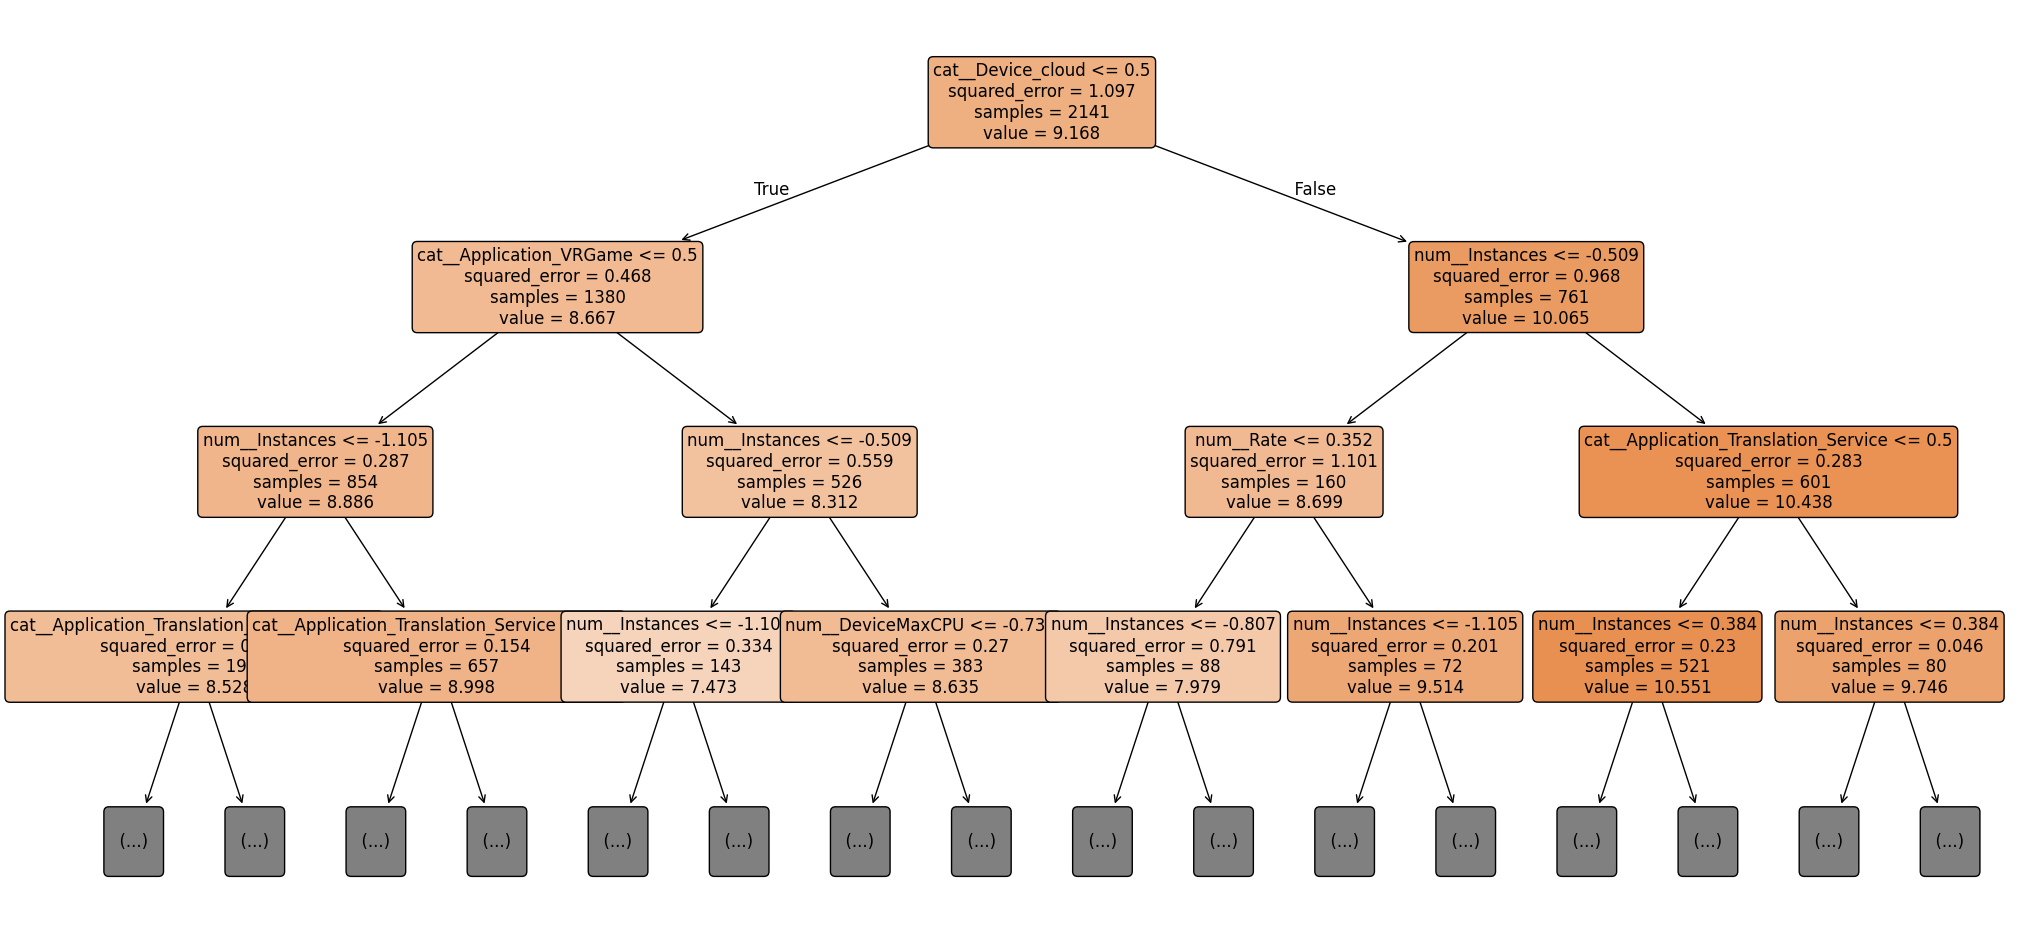

Model tree visualization saved to: rf_decision_tree.pdf


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn import tree

def save_tree_as_pdf(pipeline, filename='rf_decision_tree.pdf'):
    plt.figure(figsize=(25, 12))

    # We extract the first estimator (tree) from the forest
    # and use the feature names generated by the preprocessor
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    tree.plot_tree(pipeline.named_steps['model'].estimators_[0],
                   max_depth=3,
                   feature_names=feature_names,
                   filled=True,
                   rounded=True,
                   fontsize=12)

    #plt.title("Random Forest: Decision Tree Logic (Top Levels)", fontsize=18)
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Model tree visualization saved to: {filename}")

save_tree_as_pdf(rf_pipeline)